In [35]:
import jax
import jax.numpy as jnp
from jax import random

import flax.linen as nn
from flax import nnx

from matplotlib import colors, pyplot as plt
import colorcet as cc
from functools import partial
import os

import dataclasses

In [2]:
import numpy as np
from jax.tree_util import tree_map

In [3]:
logdir = '../metrics'
from clu import metric_writers

2024-11-04 12:38:20.581515: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730720300.811198   28485 cuda_dnn.cc:8179] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730720300.883942   28485 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
jax.devices()

[CudaDevice(id=0)]

# Input model

We consider an input that evolves as an AR(1) model:
$$
S_t = \phi S_{t-1} + \sigma\xi_t
$$
where $\xi_t$ are iid random variables from a unit Gaussian distribution, and $\phi, \sigma$ are real parameters. The autocovariance is given by
$$
\langle S_{\tau} S_{\tau + t} \rangle = \frac{\sigma^2}{1 - \phi^2} \phi^{|t|}
$$

In [25]:
class InputModel(nnx.Module):
    def __init__(self, phi=0.5, sigma=1.0, rngs = None):
        self.phi = phi
        self.sigma = sigma
        self.rngs = rngs
    
    def __call__(self, s, generate=False, rngs=None):
        phi = self.phi
        sigma = self.sigma
        std = jnp.sqrt(sigma**2 / (1 - phi**2))

        rng = self.rngs['input'] if rngs is None else rngs

        def step(carry, s):
            key, logp, s_prev = carry
            if generate:
                key, next_key = random.split(key)
                s = phi * s_prev + sigma * random.normal(key, s.shape)
            else:
                next_key = None
            logp += jax.scipy.stats.norm.logpdf(s - phi * s_prev, scale=sigma)
            return (next_key, logp, s), (s if generate else None)

        if generate:
            s0 = random.normal(rng(), s.shape[:-1]) * std
            key = rng()
        else:
            s0 = s[...,0]
            key = None

        logp_init = jax.scipy.stats.norm.logpdf(s0, scale=std)

        (_, logp, _), traj = jax.lax.scan(step, (key, logp_init, s0), s[...,1:].T)

        if generate:
            return logp, jnp.concatenate((jnp.expand_dims(s0, -1), traj.T), axis=-1)
        else:
            return logp

In [26]:
key = random.PRNGKey(42)
s_key, x_key = random.split(key)

In [27]:
s_model = InputModel(rngs=nnx.Rngs(input=s_key))
s_model

InputModel(
  phi=0.5,
  sigma=1.0,
  rngs=Rngs(
    input=RngStream(
      key=RngKey(
        value=Array(shape=(2,), dtype=uint32),
        tag='input'
      ),
      count=RngCount(
        value=Array(0, dtype=uint32),
        tag='input'
      )
    )
  )
)

In [29]:
_, s_data = s_model(jnp.empty((5000, 50)), generate=True)
plt.imshow(jnp.cov(s_data.T))
del s_data

In [30]:
def ar_cov(t, phi, sigma):
    return sigma**2 / (1.0 - phi**2) * phi**(jnp.abs(t))

In [31]:
t = jnp.arange(0, 50)

In [32]:
s_cov = ar_cov(t, s_model.phi, s_model.sigma)
s_cov_mat = jax.scipy.linalg.toeplitz(s_cov, s_cov)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(s_cov)
ax2.imshow(s_cov_mat)

In [33]:
s_probs, s = s_model(jnp.zeros((1000, 50)), generate=True, rngs=nnx.Rngs(s_key))
s_probs.shape, s.shape

((1000,), (1000, 50))

# Output Model

The output is generated via a nonlinear function applied to the input, plus independent noise.

$$
X_t = f(S_t) + \rho X_{t-1} + \theta \eta_t
$$

To compute the log-probability $\ln P(\mathbf{x}|\mathbf{s})$ we invert the process.

$$
\eta_t = \frac{1}{\theta} (X_t - \rho X_{t-1} - f(S_t))
$$



In [36]:
from typing import Optional

@dataclasses.dataclass
class LogisticModel(nnx.Module):
    gain: float
    decay: float
    noise: float
    rngs: Optional[nnx.Rngs] = None
    
    def __call__(self, s, x, generate=False, rngs = None):
        if s.ndim > 2:
            raise ValueError("s has more than 2 dimensions")
        if x.ndim > 2:
            raise ValueError("x has more than 2 dimensions")
        s = jnp.reshape(s, (-1, s.shape[-1]))
        x = jnp.reshape(x, (-1, x.shape[-1]))

        rngs = self.rngs if rngs is None else rngs
        key = rngs['generate']() if generate else None
        x_prev = jnp.zeros(x.shape[:1])
        logp = jnp.zeros(x.shape[:1]) + jnp.zeros(s.shape[:1]) # broadcasting
        
        def step(state, val):
            key, logp, x_prev = state
            s_cur, x_cur = val
            bias = jax.nn.sigmoid(s_cur * self.gain)
            if generate:
                next_key, key = random.split(key)
                x_cur = bias + self.decay * x_prev + self.noise * jax.random.normal(key, x_cur.shape)
            else:
                next_key = None
            logp += jax.scipy.stats.norm.logpdf(x_cur - self.decay * x_prev - bias, scale=self.noise)
            return (next_key, logp, x_cur), x_cur
    
        (_, logp, _), x = jax.lax.scan(step, (key, logp, x_prev), (s.T, x.T))

        if generate:
            return logp, x.T
        else:
            return logp

    def log_prob(self, s, x, full=False):
        def step(carry, val):
            logp, xprev = carry
            s, x = val
            delta = jax.scipy.stats.norm.logpdf(x - self.decay * xprev - jax.nn.sigmoid(s * self.gain), scale=self.noise)
            return (logp + delta, x), (logp+delta) if full else None
    
        (logp, _), logp_full = jax.lax.scan(step, (0.0, 0.0), [s, x])
        return logp_full if full else logp


logistic_model = LogisticModel(
    gain=10.0,
    decay=0.2,
    noise=0.2,
)
logistic_model

LogisticModel(gain=10.0, decay=0.2, noise=0.2, rngs=None)

The potential of $s$ is defined as
$$
U_n(s) = - \ln P(s) - \ln P(x_{0:n}|s) = -\ln P(s, x_{0:n})
$$
where $x_{0:n}$ is the partial $x$ trajectory from $0$ to $n$.

To compute the mutual information we need to compute the log-ratio
$$
\ln\frac{P(s, x_{0:n})}{P(s)P(x_{0:n})} = -U_n(s) - \ln P(s) - \ln\int ds\ e^{-U_n(s)}
$$

In [37]:
_, x = logistic_model(s, jnp.zeros_like(s), generate=True, rngs=nnx.Rngs(generate=x_key))
x.shape

(1000, 50)

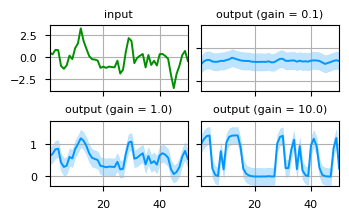

In [39]:
test_s = s[1]
time = np.arange(1,51)
with plt.rc_context({'font.size': 8}):
    fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(243 / 72, 150 / 72))
    axs[0,0].plot(time, test_s, color='#008F00')
    axs[0,0].set_title('input', fontsize=8)
    for i in [0,1]:
        axs[0,i].set_xticklabels([])
        axs[i,1].set_yticklabels([])
    for ax in axs.reshape(-1):
        ax.grid(visible=True)
        ax.set_xlim(1,50)
    for gain, coord in zip([0.1, 1.0, 10.0], [(0, 1), (1, 0), (1, 1)]):
        model = LogisticModel(gain=gain, decay=0.2, noise=0.2)
        _, test_x = model(jnp.tile(test_s, (10_000, 1)), jnp.empty((10_000, test_s.shape[0])), generate=True, rngs=nnx.Rngs(generate=x_key))
        q10 = jnp.percentile(test_x, 10, axis=0)
        q90 = jnp.percentile(test_x, 90, axis=0)
        axs[coord].plot(time, jnp.mean(test_x, axis=0), color='#0096FF')
        axs[coord].fill_between(time, q10, q90, alpha=0.25, color='#0096FF')
        axs[coord].set_title(f"output (gain = {gain})", fontsize=8)
        axs[coord].set_ylim(-0.3, 1.7)

fig.savefig('../reports/figures/input_output.pdf')
fig

# VI

First we define a variational model based on a recurrent neural network.

First we define a regular RNN (with a GRU cell):

In [81]:
class GRUCell(nnx.Module):
    def __init__(
        self, 
        in_features: int, 
        hidden_size: int, 
        rngs: nnx.Rngs,
        kernel_init = nnx.initializers.lecun_normal(),
        recurrent_kernel_init = nnx.initializers.orthogonal()
    ):
        self.hidden_size = hidden_size
        self.linear_ir = nnx.Linear(in_features, hidden_size, use_bias=True, kernel_init=kernel_init, rngs=rngs)
        self.linear_iz = nnx.Linear(in_features, hidden_size, use_bias=True, kernel_init=kernel_init, rngs=rngs)
        self.linear_in = nnx.Linear(in_features, hidden_size, use_bias=True, kernel_init=kernel_init, rngs=rngs)
        self.linear_hr = nnx.Linear(hidden_size, hidden_size, use_bias=False, kernel_init=recurrent_kernel_init, rngs=rngs)
        self.linear_hz = nnx.Linear(hidden_size, hidden_size, use_bias=False, kernel_init=recurrent_kernel_init, rngs=rngs)
        self.linear_hn = nnx.Linear(hidden_size, hidden_size, use_bias=True, kernel_init=recurrent_kernel_init, rngs=rngs)

    def __call__(self, h, x):
        r = jax.nn.sigmoid(self.linear_ir(x) + self.linear_hr(h))
        z = jax.nn.sigmoid(self.linear_iz(x) + self.linear_hz(h))
        n = jax.nn.tanh(self.linear_in(x) + r * self.linear_hn(h))
        h = (1.0 - z) * n + z * h
        return h, h

    def initial_state(self, batch_size: int):
        return jnp.zeros((batch_size, self.hidden_size))

class RNN(nnx.Module):
    def __init__(self, cell, reverse=False):
        self.reverse = reverse
        self.cell = cell
    
    def __call__(self, x, *args, return_carry=False):
        scan_fn = lambda carry, cell, x, *args: cell(carry, x, *args)
        carry = self.cell.initial_state(x.shape[0])
        carry, y = nnx.scan(
            scan_fn, state_axes={},
            in_axes=1, out_axes=1,
            reverse=self.reverse
        )(carry, self.cell, x, *args)

        if return_carry:
            return carry, y
        else:
            return y

## Variational RNN

In [77]:
def shift_right(x, axis=1):
    pad_widths = [(0, 0)] * len(x.shape)
    pad_widths[axis] = (1, 0)
    ind = [slice(None)] * len(x.shape)
    ind[axis] = slice(-1)
    return jnp.pad(x, pad_widths)[tuple(ind)]

In [692]:
def logistic_logpdf(x, mean, log_scale):
    z = (x - mean) * jnp.exp(-log_scale)
    z_half = z / 2
    return -2*jnp.logaddexp(z_half, -z_half) - log_scale

def logistic_logcdf(x, mean, log_scale):
    z = (x - mean) * jnp.exp(-log_scale)
    return jax.nn.log_sigmoid(z)

def mixlogistic_logpdf(x, prior_logits, means, log_scales):
    x = jnp.expand_dims(x, -1)
    log_pi = jax.nn.log_softmax(prior_logits, axis=-1)
    return jax.nn.logsumexp(log_pi + logistic_logpdf(x, means, log_scales), axis=-1)

def mixlogistic_logcdf(x, prior_logits, means, log_scales):
    x = jnp.expand_dims(x, -1)
    log_pi = jax.nn.log_softmax(prior_logits, axis=-1)
    return jax.nn.logsumexp(log_pi + logistic_logcdf(x, means, log_scales), axis=-1)

# coupling function from flow++
def coupling_function(x, pi, mu, log_s):
    # clipping is needed for numerical stability
    log_cdf = jnp.clip(mixlogistic_logcdf(x, pi, mu, log_s), a_max = -1e-12)
    # inverse sigmoid, i.e. logit(exp(log_cdf))
    val = log_cdf - jnp.log(-jnp.expm1(log_cdf))
    
    log_jac = mixlogistic_logpdf(x, pi, mu, log_s)
    # manually evaluate derivative log(1/(exp(log_cdf)*(1 - exp(log_cdf))))
    log_jac += - log_cdf - jnp.log(-jnp.expm1(log_cdf))
    return val, log_jac

In [693]:
class DecoderCell(nnx.Module):
    def __init__(self, in_features: int, hidden_size: int, rngs: nnx.Rngs, mixture_components: int = 5):
        self.cell = GRUCell(in_features, hidden_size, rngs=rngs)
        self.shift = nnx.Linear(hidden_size, 1, rngs=rngs)
        self.log_scale = nnx.Linear(hidden_size, 1, rngs=rngs)
        self.pi = nnx.Linear(hidden_size, mixture_components, rngs=rngs)
        self.mu = nnx.Linear(hidden_size, mixture_components, rngs=rngs)
        self.log_s = nnx.Linear(hidden_size, mixture_components, rngs=rngs)
    
    def __call__(self, carry, input, rngs: nnx.Rngs):
        rnn_state, last_prediction, logp = carry
        input = input.at[...,0].set(last_prediction)
        
        rnn_state, y = self.cell(rnn_state, input)
        
        shift = jnp.squeeze(self.shift(y), -1)
        log_scale = jnp.squeeze(self.log_scale(y), -1)
        pi = self.pi(y)
        mu = self.mu(y)
        log_s = self.log_s(y)
        
        epsilon = random.logistic(rngs(), shape=y.shape[:-1])

        val, log_jac = coupling_function(epsilon, pi, mu, log_s)
        prediction = shift + val * jnp.exp(log_scale)
        
        logp += jax.scipy.stats.logistic.logpdf(epsilon) - log_scale - log_jac
        
        return (rnn_state, prediction, logp), prediction

    def initial_state(self, batch_size: int):
        cell_state = self.cell.initial_state(batch_size)
        initial_prediction = jnp.zeros(batch_size)
        logp = jnp.zeros(batch_size)
        return (cell_state, initial_prediction, logp)


class VariationalRnn(nnx.Module):
    def __init__(self, hidden_size: int, rngs: nnx.Rngs):
        self.rngs = rngs
        self.encoder_x = RNN(GRUCell(1, hidden_size, rngs=rngs), reverse=True)
        self.decoder_rnn = RNN(DecoderCell(1 + hidden_size, hidden_size, rngs=rngs))
    
    def __call__(self, s, x, rngs = None):
        # s, x: Make input tensors of shape [batch_size, seq_length, 1]
        s = s.reshape((-1, s.shape[-1]) + (1,))
        x = x.reshape((-1, x.shape[-1]) + (1,))

        # apply reverse rnn to x
        h_x = self.encoder_x(x)

        rngs = self.rngs if rngs is None else rngs
        
        h_x = jnp.broadcast_to(h_x, s.shape[:-1] + (h_x.shape[-1],))
        s_with_context = jnp.concatenate((s, h_x), axis=-1)
        (_, _, logp), preds = self.decoder_rnn(s_with_context, rngs, return_carry=True)

        return logp, preds

In [314]:
logp, preds = VariationalRnn(64, nnx.Rngs(0))(s, x)
logp.shape, preds.shape

((1000,), (1000, 50))

## Inverse Autoregressive Flow

In [179]:
class IAFBlock(nnx.Module):
    def __init__(self, kernel_size: int,  hidden_features: int, rngs: nnx.Rngs):
        self.conv = nnx.Conv(
            in_features = 1,
            out_features = hidden_features,
            kernel_size = kernel_size,
            padding = 'CAUSAL',
            rngs=rngs
        )

        self.linear1 = nnx.Linear(
            in_features=hidden_features, 
            out_features=hidden_features, 
            rngs=rngs
        )
        self.linear2 = nnx.Linear(
            in_features=hidden_features, 
            out_features=hidden_features, 
            use_bias=False, 
            rngs=rngs
        )
        
        self.mu = nnx.Linear(in_features=hidden_features, out_features=1, rngs=rngs)
        self.s = nnx.Linear(in_features=hidden_features, out_features=1, rngs=rngs)
        self.rngs = rngs

    def __call__(self, carry, context):
        logp, z_prev = carry
        x = self.conv(shift_right(z_prev, -2))
        x = nnx.relu(self.linear1(x) + self.linear2(context))
        mu = self.mu(x)
        s = self.s(x)
        sigma = jax.nn.sigmoid(s)
        z = sigma * z_prev + (1 - sigma) * mu
        logp = logp - jnp.sum(jax.nn.log_sigmoid(s), axis=-2)
        return (logp, z), None

class IAF(nnx.Module):
    def __init__(self, kernel_size: int, hidden_features: int, depth: int, rngs: nnx.Rngs):
        self.rngs = rngs
        self.encoder_x = RNN(GRUCell(1, hidden_features, rngs=rngs), reverse=True)
        self.initial_loc = nnx.Linear(in_features=hidden_features, out_features=1, rngs=rngs)
        self.initial_log_scale = nnx.Linear(in_features=hidden_features, out_features=1, rngs=rngs)
        self.decoder = nnx.Scan.constructor(
            IAFBlock,
            in_axes=None,
            length=depth
        )(kernel_size, hidden_features, rngs=rngs)
    
    def __call__(self, s, x, rngs = None):
         # s, x: Make input tensors of shape [batch_size, seq_length, 1]
        s = s.reshape((-1, s.shape[-1]) + (1,))
        x = x.reshape((-1, x.shape[-1]) + (1,))

        rngs = self.rngs if rngs is None else rngs

        # apply reverse rnn to x
        h_x = self.encoder_x(x)
        mu = self.initial_loc(h_x)
        log_sigma = self.initial_log_scale(h_x)
        
        eps = random.normal(rngs(), s.shape)
        z = jnp.exp(log_sigma) * eps + mu
        logp = -jnp.sum(log_sigma + 0.5 * eps**2 + 0.5 * jnp.log(2*jnp.pi), axis=-2)

        h_x = jnp.broadcast_to(h_x, s.shape[:-1] + (h_x.shape[-1],))
        result, _ = self.decoder((logp, z), h_x)
        
        return tree_map(lambda x: jnp.squeeze(x, -1), result)

## Training loop

In [193]:
model_dim = 256
# variational_model = VariationalRnn(model_dim, rngs=nnx.Rngs(0))
variational_model = IAF(9, model_dim, 8, rngs=nnx.Rngs(0))

In [194]:
import optax
from flax.training import train_state

optimizer = nnx.Optimizer(variational_model, optax.adam(1e-4))

def elbo_loss(variational_model, key, batch_size=32, subsample=1):
    s_key, x_key, elbo_key = random.split(key, 3)
    _, s = s_model(jnp.empty((batch_size, 50)), generate=True, rngs=nnx.Rngs(s_key))
    _, x = logistic_model(s, jnp.empty_like(s), generate=True, rngs=nnx.Rngs(x_key))
    def elbo_sample(subkey):
        logq_s, preds = variational_model(jnp.empty_like(x), x)
        logp_s = s_model(preds)
        log_cond = logistic_model(preds, x)
        return (logp_s, log_cond, logq_s)
    logp_s, log_cond, logq_s = jax.vmap(elbo_sample)(jax.random.split(elbo_key, subsample))
    loss = -jnp.mean(logp_s + log_cond - logq_s)
    log_prior = jnp.mean(logp_s)
    log_likelihood = jnp.mean(log_cond)
    log_posterior = jnp.mean(logq_s)
    return loss, {'loss': loss, 'log_prior': log_prior, 'log_likelihood': log_likelihood, 'log_posterior': log_posterior}

writer = metric_writers.create_default_writer(os.path.join(logdir, 'VAE'))

loss, metrics = elbo_loss(variational_model, key, batch_size=1024, subsample=8)
writer.write_scalars(0, metrics)
loss

Array(294.9693, dtype=float32)

In [195]:
@nnx.jit
def train_step(variational_model, optimizer, key):
    grad_fn = nnx.value_and_grad(elbo_loss, argnums=0, has_aux=True)
    (loss, metrics), grads = grad_fn(variational_model, key, 1024, 8)
    optimizer.update(grads)
    return loss, metrics

num_steps = 2000
for epoch in range(num_steps):
    epoch_key = jax.random.fold_in(key, optimizer.step.value)
    loss, metrics = train_step(variational_model, optimizer, epoch_key)
    writer.write_scalars(optimizer.step.value, metrics)

## Evaluate

In [196]:
def generate(model, x, N=1):
    s = jnp.empty((N,) + x.shape)
    return model(s, x)

2024-07-08 10:21:13.838782: W external/tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 80.58GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


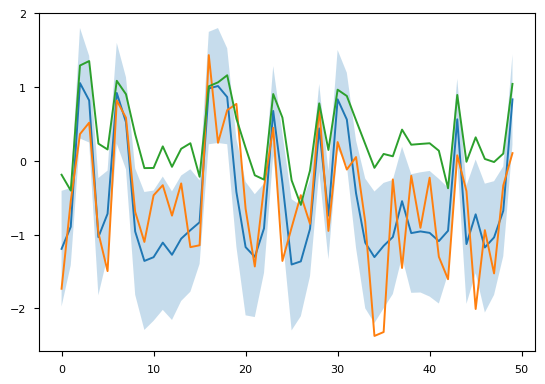

In [197]:
i = 0

logp, preds = generate(variational_model, x[i], 10_000)
median = jnp.median(preds, axis=0)
q5 = jnp.percentile(preds, 5, axis=0)
q95 = jnp.percentile(preds, 95, axis=0)
plt.fill_between(range(preds.shape[1]), q5, q95, alpha=0.25)
plt.plot(median)
plt.plot(s[i])
plt.plot(x[i])

Now we want to compute the importance weights $P(s)P(x|s)/q(s|x)$ for trajectories sampled from $q(s|x)$.

(Array(0.00160665, dtype=float32),
 Array(-39.119507, dtype=float32),
 Array(-29.684372, dtype=float32))

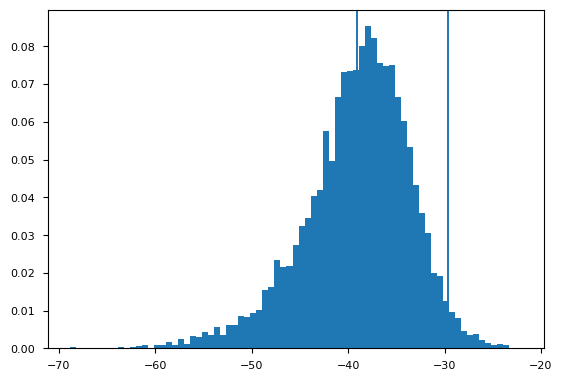

In [198]:
logq_s, preds = generate(variational_model, x[i], 10_000)
logp_s = s_model(preds)
log_cond = model(preds, x[i])
log_weights = logp_s - logq_s + log_cond
log_p_x_estimate = jax.nn.logsumexp(log_weights) - jnp.log(log_weights.shape[0])
elbo = jnp.mean(log_weights)
ess = 1 / jnp.sum(jax.nn.softmax(log_weights)**2)
plt.hist(log_weights, bins='auto', density=True)
plt.axvline(log_p_x_estimate)
plt.axvline(elbo)
ess / preds.shape[0], elbo, log_p_x_estimate

(Array(0.00011252, dtype=float32),
 Array(-276.10577, dtype=float32),
 Array(-123.53649, dtype=float32))

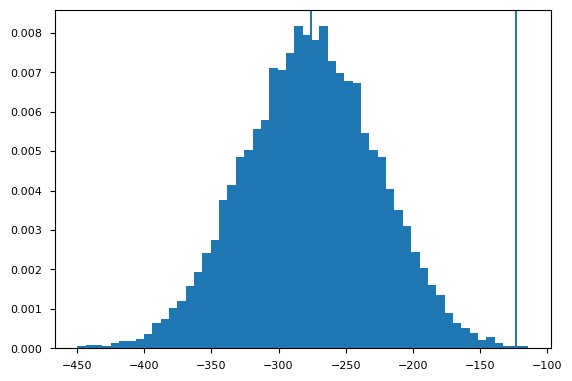

In [186]:
_, prior_samples = s_model(jnp.empty((10_000, 50)), generate=True)
log_cond = model(prior_samples, x[i])
log_weights = log_cond
log_p_x_estimate = jax.nn.logsumexp(log_weights) - jnp.log(log_cond.shape[0])
elbo = jnp.mean(log_weights)
ess = 1 / jnp.sum(jax.nn.softmax(log_weights)**2)
plt.hist(log_weights, bins='auto', density=True)
plt.axvline(log_p_x_estimate)
plt.axvline(elbo)
ess / prior_samples.shape[0], elbo, log_p_x_estimate

In [641]:
model(prior_samples, x[0])

Array([-2.7244766, -2.4699862, -3.3651204, ..., -2.8142664, -1.696842 ,
       -3.8374457], dtype=float32)

# SMC

In [299]:
def resample(key, logits, s):
    indices = jax.random.categorical(key, logits, shape=logits.shape)
    return s[indices], jnp.zeros(logits.shape), jax.nn.logsumexp(logits) - jnp.log(logits.shape[0])

def smc_estimate(key, x, params, phi=0.5, sigma=0.5, n_particles=512):
    gain, decay, noise = [params[k] for k in ('gain', 'decay', 'noise')]
    s = jnp.zeros(n_particles)
    log_weights = jnp.zeros(n_particles)
    log_norm_estimate = 0.0
    
    def smc_step(carry, val):
        xprev, s, log_weights, log_norm_estimate, key = carry
        x = val
        key, next_key = random.split(key)
        
        def propagate(val):
            s_prev, log_weight, key = val
            s = phi * s_prev + sigma * jax.random.normal(key)
            delta_w = jax.scipy.stats.norm.logpdf(x - decay * xprev - jax.nn.sigmoid(s * gain), scale=noise)
            return s, log_weight + delta_w
    
        s, log_weights = jax.lax.map(propagate, [s, log_weights, random.split(key, n_particles)])

        # Calculate normalized weights and effective sample size (ESS)
        normalized_weights = jax.nn.softmax(log_weights)
        ess = 1.0 / jnp.sum(normalized_weights**2)

        # Threshold for resampling, could be set to N/2 for particle count N
        s, new_log_weights, log_norm_change = jax.lax.cond(
            ess < n_particles // 3,
            resample,
            lambda key, log_weights, s: (s, log_weights, 0.0),
            key, log_weights, s
        )
        
        return (x, s, new_log_weights, log_norm_estimate + log_norm_change, next_key), (log_weights, log_norm_estimate + jax.nn.logsumexp(log_weights) - jnp.log(n_particles))
        
    return jax.lax.scan(smc_step, (0.0, s, log_weights, log_norm_estimate, key), x)[1]

In [300]:
log_weights.shape

(50, 30000)

(0.0, 1.0)

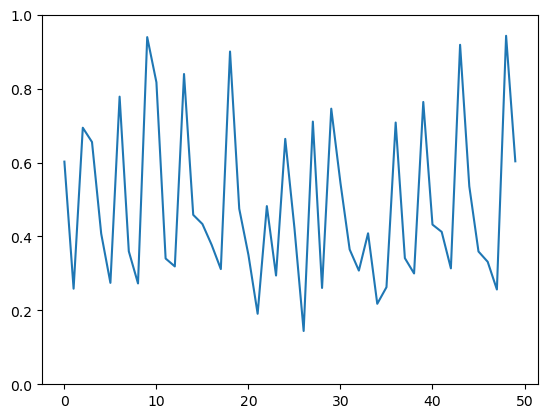

In [304]:
log_weights, log_norm_estimate = smc_estimate(key, x[0], params, n_particles=3000)
ess = 1.0 / jnp.sum(jax.nn.softmax(log_weights, axis=1)**2, axis=1) / log_weights.shape[1]
# plt.plot(log_norm_estimate)
plt.plot(ess)
plt.ylim(0, 1)

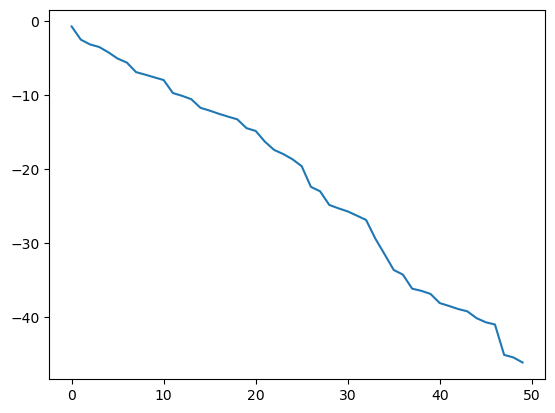

In [305]:
plt.plot(log_norm_estimate)

# Annealed Importance Sampling

## Hamiltonian Monte Carlo

Implement a basic hamiltonian Monte Carlo algorithm

In [1669]:
# perform N leapfrog steps
def leapfrog(potential, p, s, M_inv, epsilon, N):
    pot_grad = jax.vmap(jax.grad(potential))

    # first half step for momentum
    p_half = p - 0.5 * epsilon * pot_grad(s)
    def body(i, val):
        p, s = val
        s_full = s + epsilon * jnp.einsum('jk,ik->ij', M_inv, p)
        p_full = p - epsilon * pot_grad(s_full)
        return p_full, s_full
    p, s = jax.lax.fori_loop(0, N-1, body, (p_half, s))

    # final full step
    s_full = s + epsilon * jnp.einsum('jk,ik->ij', M_inv, p)
    p_full = p - 0.5 * epsilon * pot_grad(s_full)

    return p_full, s_full

We perform HMC in the extended space of multiple input-output trajectories. The extended potential is

$$
U_n(s_1,\ldots,s_N, x_1,\ldots,x_N) = \sum^N_{i=1} U_n(s_i, x_i)
$$

with the corresponding partition function

$$
Z_n(x_1,\ldots,x_N) = \int ds_1 \cdots \int ds_N\ e^{-U_n(s_1,\ldots,s_N, x_1,\ldots,x_N)} = \prod^N_{i=1} Z_n(x_i)
$$

In [1622]:
def hamiltonian(potential, p, s, M_inv):
    pot = jax.vmap(potential)(s)
    kin = 0.5 * jnp.einsum('ij,jk,ik->i', p, M_inv, p)
    return pot + kin

In [1670]:
def mc_step(key, potential, s, M, M_inv, epsilon=1e-4, N=100):
    init_key, key = random.split(key)
    p_init = jax.random.multivariate_normal(init_key, jnp.zeros(s.shape), M)
    orig_hamiltonian = hamiltonian(potential, p_init, s, M_inv)
    
    p_new, s_new = leapfrog(potential, p_init, s, M_inv, epsilon, N)
    current_hamiltonian = hamiltonian(potential, p_new, s_new, M_inv)
    
    p_accept = jnp.exp(orig_hamiltonian - current_hamiltonian)
    rand = random.uniform(key, p_accept.shape)

    jax.debug.print('accept: {x}', x=jnp.mean(jnp.minimum(1.0, p_accept)))

    return jnp.where(jnp.expand_dims(p_accept > rand, -1), s_new, s)

In [1468]:
def mcmc_chain(key, potential, s, length=1, epsilon=1e-4, N=100):
    def body(s, subkey):
        s_new = mc_step(subkey, potential, s, epsilon, N)
        pot = jax.vmap(potential)(s_new)
        return (s_new, {'chain': s_new, 'potential': pot})
    _, result = jax.lax.scan(body, s, random.split(key, length))
    return result

In [1469]:
class McmcModel(nn.Module):
    prior: nn.Module
    likelihood: nn.Module

    def potential(self, s, x, theta=1.0):
        s = jnp.expand_dims(s, 0)
        x = jnp.expand_dims(x, 0)
        return - (self.prior(s) + theta * self.likelihood(s, x))[0]


In [1366]:
mcmc_model = McmcModel(InputModel(), LogisticModel(1.0, 0.2, 0.2))
mcmc_vars = mcmc_model.init(key, s[0], x[0], method=McmcModel.potential)

def potential(s):
    return mcmc_model.apply(mcmc_vars, s, x[0], theta=1.0, method='potential')

result = mcmc_chain(key, potential, s[:1024], length=50, N=100, epsilon=1e-3)

E0526 18:46:07.483887  428836 pjrt_stream_executor_client.cc:2804] Execution of replica 0 failed: INTERNAL: CustomCall failed: CpuCallback error: KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/jax/_src/interpreters/mlir.py(2446): _wrapped_callback
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/jax/_src/interpreters/pxla.py(1201): __call__
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/jax/_src/profiler.py(336): wrapper
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/jax/_src/pjit.py(1348): _pjit_call_impl_python
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/jax/_src/pjit.py(1392): call_impl_cache_miss
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/jax/_src/pjit.py(1409): _pjit_call_impl
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/jax/_src/core.py(913): process_primitive
  /home/mreinhardt/.conda/envs/ml-pws/lib/p

XlaRuntimeError: INTERNAL: CustomCall failed: CpuCallback error: KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/jax/_src/interpreters/mlir.py(2446): _wrapped_callback
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/jax/_src/interpreters/pxla.py(1201): __call__
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/jax/_src/profiler.py(336): wrapper
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/jax/_src/pjit.py(1348): _pjit_call_impl_python
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/jax/_src/pjit.py(1392): call_impl_cache_miss
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/jax/_src/pjit.py(1409): _pjit_call_impl
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/jax/_src/core.py(913): process_primitive
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/jax/_src/core.py(423): bind_with_trace
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/jax/_src/core.py(2727): bind
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/jax/_src/pjit.py(143): _python_pjit_helper
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/jax/_src/pjit.py(248): cache_miss
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/jax/_src/traceback_util.py(179): reraise_with_filtered_traceback
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/jax/_src/dispatch.py(87): apply_primitive
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/jax/_src/core.py(913): process_primitive
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/jax/_src/core.py(423): bind_with_trace
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/jax/_src/core.py(2727): bind
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/jax/_src/lax/control_flow/loops.py(1157): scan_bind
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/jax/_src/lax/control_flow/loops.py(281): scan
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/jax/_src/traceback_util.py(179): reraise_with_filtered_traceback
  /tmp/ipykernel_428836/3732678825.py(6): mcmc_chain
  /tmp/ipykernel_428836/3130217276.py(7): <module>
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3550): run_code
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3490): run_ast_nodes
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3308): run_cell_async
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/IPython/core/async_helpers.py(129): _pseudo_sync_runner
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3103): _run_cell
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3048): run_cell
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/ipykernel/zmqshell.py(549): run_cell
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/ipykernel/ipkernel.py(446): do_execute
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/ipykernel/kernelbase.py(778): execute_request
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/ipykernel/ipkernel.py(359): execute_request
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/ipykernel/kernelbase.py(437): dispatch_shell
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/ipykernel/kernelbase.py(534): process_one
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/ipykernel/kernelbase.py(545): dispatch_queue
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/asyncio/events.py(80): _run
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/asyncio/base_events.py(1890): _run_once
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/asyncio/base_events.py(596): run_forever
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/tornado/platform/asyncio.py(205): start
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/ipykernel/kernelapp.py(739): start
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/traitlets/config/application.py(1075): launch_instance
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/site-packages/ipykernel_launcher.py(18): <module>
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/runpy.py(87): _run_code
  /home/mreinhardt/.conda/envs/ml-pws/lib/python3.9/runpy.py(197): _run_module_as_main


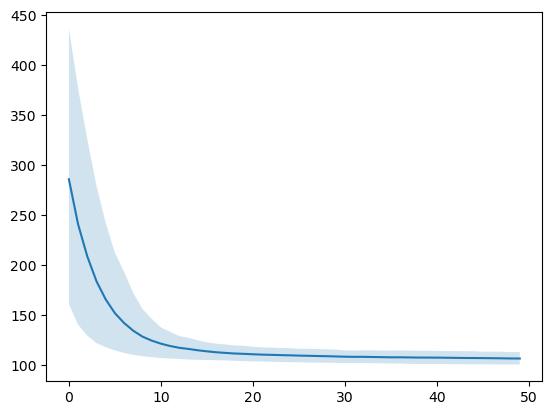

In [1315]:
p = result['potential']
plt.plot(jnp.mean(p, axis=1));
plt.fill_between(jnp.arange(p.shape[0]), jnp.percentile(p, 10, axis=1), jnp.percentile(p, 90, axis=1), alpha=0.2);

In [1680]:
def annealed_importante_sampling(key, potential, s, M, theta, epsilon=1e-5, N=500):
    M_inv = jnp.linalg.inv(M)
    def body(s, n):
        subkey = random.fold_in(key, n)
        log_w = jax.vmap(lambda s: potential(s, theta[n]) - potential(s, theta[n-1]))(s)
        potential_theta = lambda s: potential(s, theta[n])
        s_new = mc_step(subkey, potential_theta, s, M, M_inv, epsilon * (1 - theta[n-1]), N)
        return s_new, log_w

    samples, log_w = jax.lax.scan(body, s, jnp.arange(theta.shape[0] - 1) + 1)
    return samples, jnp.cumsum(log_w, axis=0)

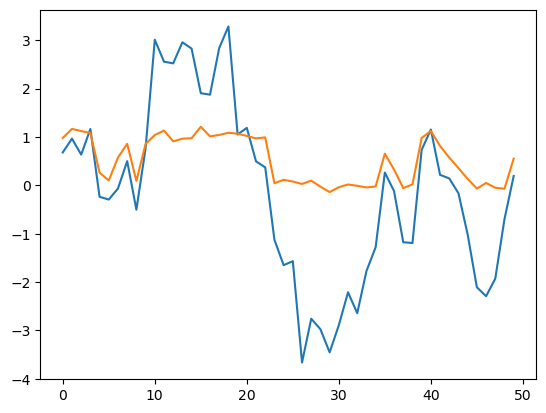

In [1645]:
_, s = InputModel().apply({'params': s_params}, jnp.zeros((1000, 50)), generate=True, rngs={'input': s_key})
_, x = LogisticModel(5.0, 0.1, 0.1).apply({}, s, jnp.zeros_like(s), generate=True, rngs={'rnn': x_key})
plt.plot(s[0])
plt.plot(x[0])

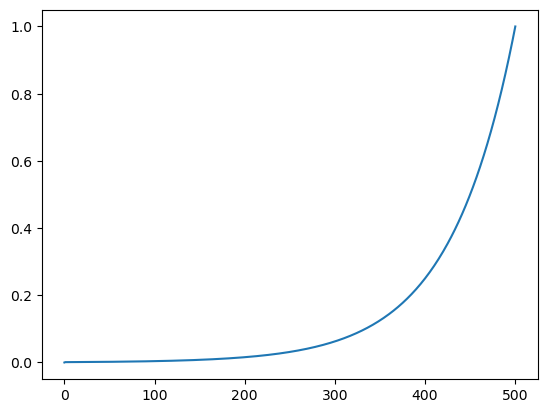

In [1675]:
theta = jnp.concat([jnp.array([0.0]), jnp.geomspace(1e-3, 1.0, 500)])
plt.plot(theta)

In [1688]:
mcmc_model = McmcModel(InputModel(), LogisticModel(5.0, 0.1, 0.1))
mcmc_vars = mcmc_model.init(key, s[0], x[0], method=McmcModel.potential)
mcmc_vars['params']['prior'] = s_params

def potential(s, theta):
    return mcmc_model.apply(mcmc_vars, s, x[0], theta=theta, method='potential')

M = s_cov_mat

result = annealed_importante_sampling(key, potential, s[1:], M, theta, N=100, epsilon=0.2)

accept: 0.8612096905708313
accept: 0.8674585223197937
accept: 0.8587872385978699
accept: 0.8567119240760803
accept: 0.852104902267456
accept: 0.85615074634552
accept: 0.8690367341041565
accept: 0.8515203595161438
accept: 0.8548889756202698
accept: 0.8510934114456177
accept: 0.8546473383903503
accept: 0.8529846668243408
accept: 0.8536285758018494
accept: 0.8582532405853271
accept: 0.8571532964706421
accept: 0.8532143831253052
accept: 0.8606187701225281
accept: 0.862377405166626
accept: 0.8517885208129883
accept: 0.8476458787918091
accept: 0.8692120909690857
accept: 0.8656930923461914
accept: 0.8621188402175903
accept: 0.8571965098381042
accept: 0.8621097803115845
accept: 0.8556904196739197
accept: 0.8549893498420715
accept: 0.8495052456855774
accept: 0.8485162258148193
accept: 0.851973831653595
accept: 0.8505164980888367
accept: 0.8547255992889404
accept: 0.8608940243721008
accept: 0.8468186855316162
accept: 0.8600587844848633
accept: 0.8507875800132751
accept: 0.8620066046714783
accept

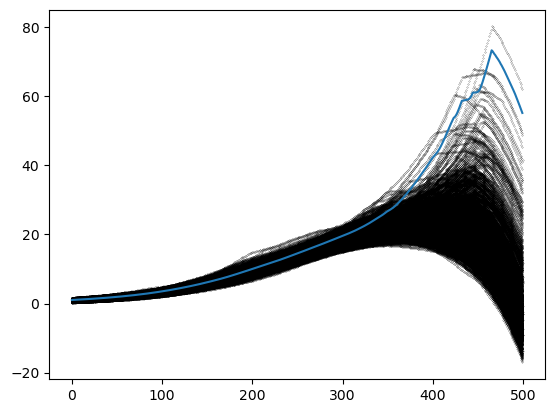

In [1689]:
plt.scatter(jnp.expand_dims(jnp.arange(result[1].shape[0]), 1) + random.normal(key, result[1].shape) * 0.08, result[1], marker='.', s=0.1, color='black');
plt.plot(jax.nn.logsumexp(result[1], axis=1) - jnp.log(result[1].shape[1]))

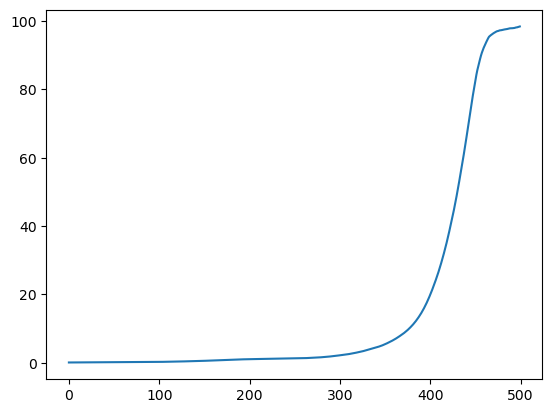

In [1690]:
plt.plot(jnp.var(result[1], axis=-1))

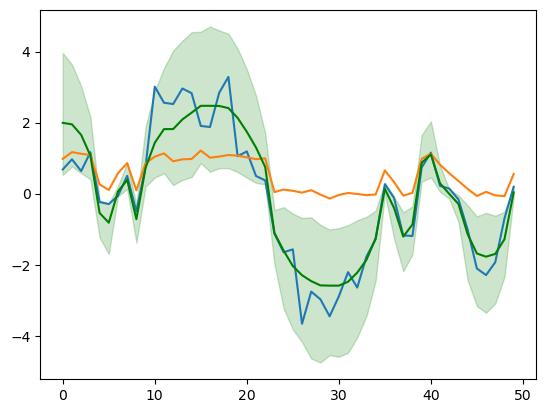

In [1691]:
plt.plot(s[0])
plt.plot(x[0])
preds = result[0]
plt.plot(jnp.mean(preds, axis=0), color='green')
plt.fill_between(jnp.arange(preds.shape[-1]), jnp.percentile(preds, 5, axis=0), jnp.percentile(preds, 95, axis=0), alpha=0.2, color='green')

In [185]:
class MCMCSimulation:
    def __init__(self, model, data, params, key=random.key(37), length=None):
        self.model = model
        self.data = data
        self.params = params
        self.chains = None
        self.diagnostics = {}
        self.key = key
        if length is None:
            length = data.shape[-1]
        self.length = length

    def run(self, n_iterations, n_chains, epsilon=1e-5, N=500):
        x = self.data
        params = self.params
        length = self.length
        def simulate_chain(key):
            s = sample_s(key)[0]
            def body(s, subkey):
                s_new = mc_step(subkey, s, x, params, length, epsilon * length**2, N)
                pot = potential(s_new, x, params, length) - potential(s_new, x, params, 0)
                return s_new, {"chain": s_new, "pot": pot}
            _, chain = jax.lax.scan(body, s, random.split(key, n_iterations))
            return chain
        result = jax.lax.map(simulate_chain, random.split(self.key, n_chains))
        self.chains = result["chain"]
        self.diagnostics = {"potential": result["pot"]}

In [186]:
mcmc_sim = MCMCSimulation(None, x[0], params, length=10)

In [188]:
%time mcmc_sim.run(200, 16, N=100, epsilon=1e-6)

CPU times: user 31.3 s, sys: 28.2 s, total: 59.4 s
Wall time: 59.2 s


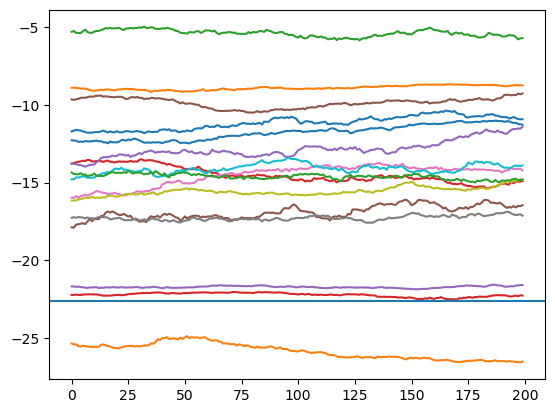

In [189]:
for i in range(mcmc_sim.chains.shape[0]):
    log_cond_samples = - mcmc_sim.diagnostics["potential"][i]
    plt.plot(jnp.arange(log_cond_samples.shape[0]), log_cond_samples)
plt.axhline(log_conditional(s[0], x[0], params))

<ErrorbarContainer object of 3 artists>

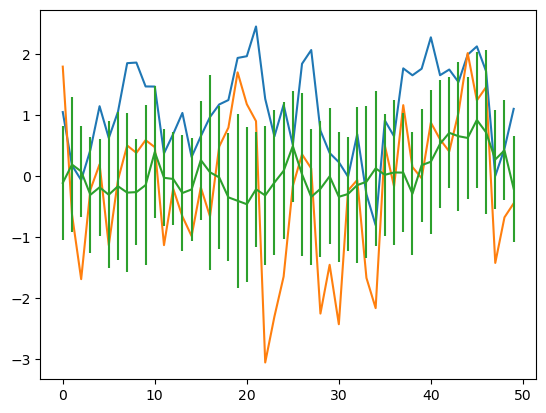

In [190]:
converged = mcmc_sim.chains[:, -1, :]
indep = sample_s(key, 100)
plt.plot(x[0])
plt.plot(s[0])
# plt.plot(jnp.mean(converged, axis=0), linewidth=2, color="black")
plt.errorbar(x=jnp.arange(converged.shape[-1]), y=jnp.mean(converged, axis=0), yerr=jnp.std(converged, axis=0))
# plt.errorbar(x=jnp.arange(indep.shape[-1]), y=jnp.mean(indep, axis=0), yerr=jnp.std(indep, axis=0))

In [587]:
# fig, ax = plt.subplots()

# x_lines = ax.plot(x[0])[0]
# s_lines = ax.plot(samples[0, 0, 0])[0]
# ax.set_ylim(-2.5, 2.5)

# def update(frame):
#     s_lines.set_ydata(samples[0, frame, 0])
#     return x_lines, s_lines

# ani = animation.FuncAnimation(fig=fig, func=update, frames=samples.shape[1], interval=4)
# ani.save(filename="animation.gif", writer="pillow")

We perform thermodynamic integration. We define a sequence of unnormalized probability distributions
$$
f_n(s) = e^{-U_n(s)}\quad\text{for }n=0,1,2,\ldots,L
$$
with the corresponding normalization constants
$$
z_n = \int ds\ e^{-U_n(s)} \,.
$$

We observe that $z_0 = \int ds\ P(s) = 1$. Therefore we can compute $z_n$ by computing the ratio $z_n/z_0$. This can be done using Annealed Importance Sampling.

$$
\frac{f_n(s_n)}{f_{n+1}(s_n)} = e^{-[U_n(s_n) - U_{n+1}(s_n)]}
$$

In [763]:
result = annealed_importante_sampling(key, x[0], params, 10, epsilon=1e-6, N=500)

In [764]:
result.shape

(10, 50)

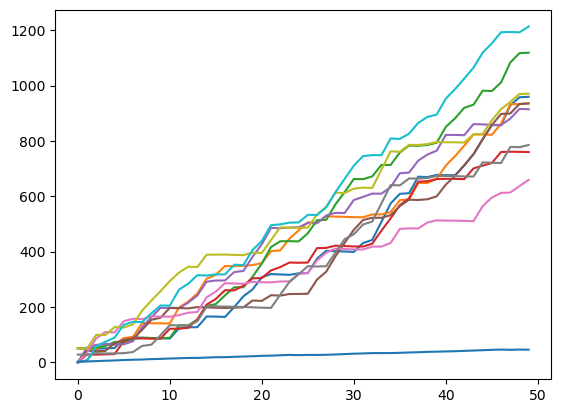

In [765]:
plt.plot(result.T)
pot = potential(s[0], x[0], params)
plt.plot(-(pot - pot[0])[1:])

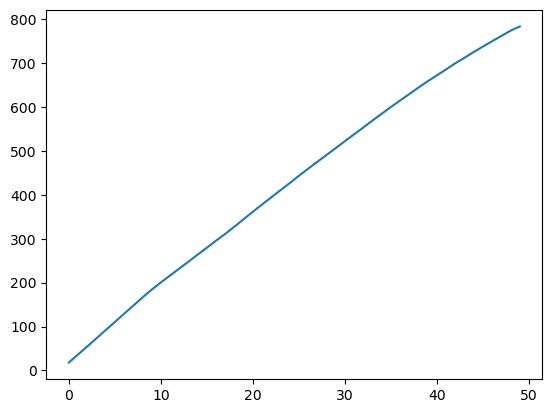

In [680]:
log_p_x = -jnp.mean(result, axis=0) / x.shape[0]
log_p_s = jnp.mean(jax.scipy.stats.multivariate_normal.logpdf(s, jnp.zeros(s_cov_mat.shape[0]), s_cov_mat))
log_p_s_x = -jnp.mean(potential(s, x, params), axis=0)[:-1]
plt.plot(log_p_s_x - log_p_s - log_p_x)

# Gaussian Information

In [218]:
def cross_corr(data):
    N, L = data.shape[1:]
    result = jax.lax.conv(data, data, (1,), ((L, L),)) / N / L
    return jnp.arange(-L,L+1), jnp.transpose(result, (1,0,2))

def plot_cross_corr(data):
    lags, corr = cross_corr(data)
    plt.plot(lags, corr[0, 0], label="$\\langle s(t) s(t+\\Delta t)\\rangle$")
    plt.plot(lags, corr[0, 1], label="$\\langle s(t) x(t+\\Delta t)\\rangle$")
    plt.plot(lags, corr[1, 1], label="$\\langle x(t) x(t+\\Delta t)\\rangle$")
    plt.xlabel("$\\Delta t$")
    plt.grid()
    plt.legend()

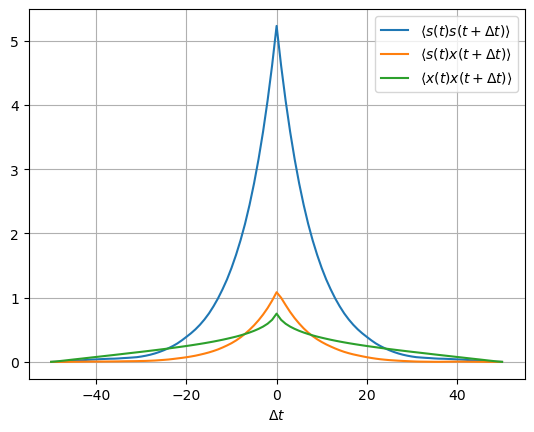

In [219]:
_, val_s = s_model(jnp.empty((2**12, 50)), generate=True)
_, val_x = logistic_model(val_s, jnp.empty_like(val_s), generate=True, rngs=nnx.Rngs(0))
plot_cross_corr(jnp.stack((val_s, val_x)))

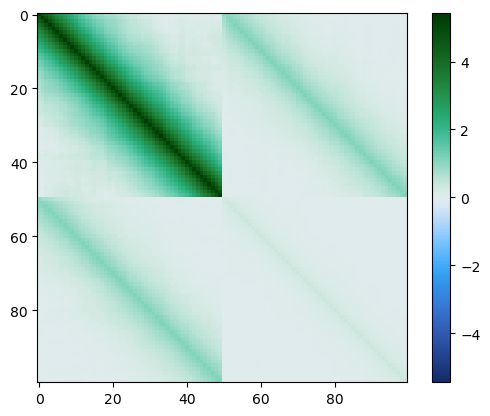

In [220]:
def plot_cov_matrix(input, output):
    data = jnp.concat((input.T, output.T), axis=0)
    plt.imshow(jnp.cov(data), norm=colors.CenteredNorm(), cmap=cc.m_CET_D13)
    plt.colorbar()
    
plot_cov_matrix(val_s, val_x)

In [41]:
def logdet_cholesky(matrix):
    L = jax.scipy.linalg.cholesky(matrix, lower=True)
    return 2.0 * jnp.sum(jnp.log(jnp.diag(L)))

@jax.jit
def gaussian_mi(s, x):
    s = s - jnp.mean(s)
    x = x - jnp.mean(x)
    L = s.shape[-1]
    data = jnp.concat((s.T, x.T), axis=0)
    cov_z = jnp.cov(data)
    cov_ss = cov_z[:L, :L]
    cov_xx = cov_z[L:, L:]

    logdet_ss = logdet_cholesky(cov_ss)
    logdet_xx = logdet_cholesky(cov_xx)
    logdet_z = logdet_cholesky(cov_z)
    
    return 0.5 * (logdet_ss + logdet_xx - logdet_z)

# Forward Model

## RNN model

In [79]:
class PredictiveCell(nnx.Module):
    def __init__(self, hidden_size: int, rngs: nnx.Rngs):
        self.rngs = rngs
        self.cell = GRUCell(2, hidden_size, rngs=rngs)
        self.dense = nnx.Linear(hidden_size, 2, rngs=rngs)
    
    def __call__(self, carry, s, x, generate=True):
        cell_state, last_prediction = carry
        if generate:
            x = jnp.expand_dims(last_prediction, -1)

        cell_state, y = self.cell(cell_state, jnp.concat((s, x), axis=-1))
        y = self.dense(y)
        mean, log_var = (jnp.squeeze(arr, -1) for arr in jnp.split(y, 2, axis=-1))

        if not generate:
            prediction = None
        else:
            rng = self.rngs['generate']
            prediction = mean + random.normal(rng(), shape=log_var.shape) * jnp.exp(log_var / 2)
        return (cell_state, prediction), ((mean, log_var), prediction)

    def initial_state(self, batch_size: int, generate=True):
        cell_state = self.cell.initial_state(batch_size)
        initial_prediction = jnp.zeros(batch_size) if generate else None
        return (cell_state, initial_prediction)
    

class Sequence(nnx.Module):
    def __init__(self, hidden_size: int, rngs: nnx.Rngs):
        self.cell = PredictiveCell(hidden_size, rngs)

    def __call__(self, s, x, generate=False):
        s = jnp.expand_dims(s, -1)
        x = jnp.expand_dims(x, -1)

        if not generate:
            target = jnp.squeeze(x, -1)
            x = shift_right(x, -2)

        s, x = jnp.broadcast_arrays(s, x)

        scan_fn = lambda carry, cell, s, x: cell(carry, s, x, generate)
        carry = self.cell.initial_state(x.shape[0], generate)
        carry, ((mean, log_var), preds) = nnx.scan(
            scan_fn, state_axes={},
            in_axes=-2, out_axes=-1,
        )(carry, self.cell, s, x)

        if generate:
            target = preds

        logp = jnp.sum(jax.scipy.stats.norm.logpdf(target, loc=mean, scale=jnp.exp(log_var / 2)), axis=-1)
        if generate:
            return logp, preds
        else:
            return logp

In [80]:
model = Sequence(hidden_size=16, rngs=nnx.Rngs(x_key))
model(s, x).shape

NameError: name 'GRUCell' is not defined

## Convolutional Model

In [82]:
class ConvolutionalAutoregressiveModel(nnx.Module):
    def __init__(self, kernel_size: int,  hidden_features: int, num_layers: int, rngs: nnx.Rngs):
        self.layers = [
            nnx.Conv(
                in_features = (2 if i==0 else hidden_features),
                out_features = hidden_features,
                kernel_size = kernel_size,
                padding = 'CAUSAL',
                rngs=rngs
            )
            for i in range(num_layers)
        ]
        self.loc = nnx.Linear(in_features=hidden_features, out_features=1, rngs=rngs)
        self.log_scale = nnx.Linear(in_features=hidden_features, out_features=1, rngs=rngs)
        self.rngs = rngs

    def forward(self, s, x):
        z = jnp.concat((s, x), axis=-1)
        for conv in self.layers:
            z = jax.nn.relu(conv(z))
        loc = self.loc(z)
        log_scale = self.log_scale(z)
        return loc, log_scale

    def __call__(self, s, x, generate=False):
        s = jnp.expand_dims(s, -1)

        if generate:
            x = jnp.zeros(x.shape + (1,))
        else:
            x = jnp.expand_dims(x, -1)
            target = x
            x = shift_right(x, -2)

        s, x = jnp.broadcast_arrays(s, x)

        def step(pred, mod, i):
            loc, log_scale = mod.forward(s, shift_right(pred, -2))
            key = mod.rngs()
            loc = loc[...,i,:]
            log_scale = log_scale[...,i,:]
            eps = loc + jax.random.normal(key, loc.shape) * jnp.exp(log_scale)
            pred = pred.at[...,i,:].set(eps)
            return pred, (loc, log_scale)

        if generate:
            pred, (loc, log_scale) = nnx.scan(step, state_axes={}, out_axes=-2)(x, self, jnp.arange(x.shape[-2]))
            target = pred
        else:
            loc, log_scale = self.forward(s, x)

        logp = jnp.sum(jnp.squeeze(jax.scipy.stats.norm.logpdf(target, loc, jnp.exp(log_scale)), axis=-1), axis=-1)
        
        if generate:
            return logp, jnp.squeeze(pred, -1)
        else:
            return logp

model = ConvolutionalAutoregressiveModel(1, 16, 8, rngs=nnx.Rngs(0))
model(s, x).shape

(1000,)

## Training Loop

In [83]:
import optax

optimizer = nnx.Optimizer(model, optax.adam(1e-3))

forward_writer = metric_writers.create_default_writer(os.path.join(logdir, 'Forward'))

def forward_loss(model, s, x):
    log_likelihood = model(s, x)
    loss = -jnp.mean(log_likelihood)
    kl_div = jnp.mean(logistic_model(s, x) - log_likelihood)
    return loss, {'loss': loss, 'kl_div': kl_div}

loss, metrics = forward_loss(model, s, x)
forward_writer.write_scalars(0, metrics)
loss

I0000 00:00:1719579330.115225  478462 cuda_executor.cc:989] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
W0000 00:00:1719579330.140225  478462 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Array(63.51897, dtype=float32)

In [84]:
@nnx.jit
def train_step(model, optimizer, s_batch, x_batch):
    grad_fn = nnx.value_and_grad(forward_loss, has_aux=True)
    (loss, metrics), grads = grad_fn(model, s_batch, x_batch)
    optimizer.update(grads=grads)
    return loss, metrics

In [85]:
num_epochs = 200
batch_size = 32
for epoch in range(num_epochs):
    num_samples = s.shape[0]
    epoch_key = random.fold_in(key, epoch)
    perm = random.permutation(epoch_key, num_samples)
    s_shuffle = s[perm]
    x_shuffle = x[perm]
    for j in range(0, num_samples, batch_size):
        s_batch = s_shuffle[j:j+batch_size]
        x_batch = x_shuffle[j:j+batch_size]
        train_step(model, optimizer, s_batch, x_batch)
    loss, metrics = forward_loss(model, s, x)
    forward_writer.write_scalars(epoch, metrics)

## Evaluation

First we create validation data that was not used for training.

In [86]:
_, val_s = s_model(jnp.empty((10_000, 50)), generate=True, rngs=nnx.Rngs(0))
val_logp_x, val_x = logistic_model(val_s, jnp.empty_like(val_s), generate=True, rngs=nnx.Rngs(1))
val_s.shape, val_x.shape

((10000, 50), (10000, 50))

Using the validation data we can estimate the forward KL divergence $KL(P_\mathrm{true} || P_\mathrm{nn})$ between true distribution and learned distribution.

In [87]:
logp_nn = model(val_s, val_x)
jnp.mean(val_logp_x - logp_nn).item()

0.11218373477458954

As well as the reverse KL divergence $KL(P_\mathrm{nn}||P_\mathrm{true})$

In [104]:
logp_nn, preds = model(val_s, val_s, generate=True)
logp_true = logistic_model(val_s, preds)
jnp.mean(logp_nn - logp_true).item()

0.12303825467824936

<BarContainer object of 123 artists>

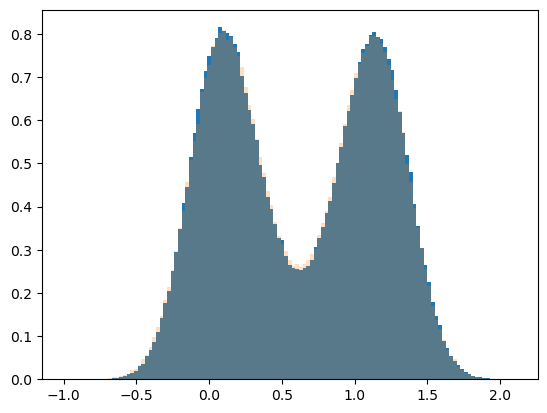

In [110]:
bin_edges = np.histogram_bin_edges(val_x, bins='fd')
vals, bin_edges = jnp.histogram(val_x, bins=bin_edges, density=True)
plt.bar(bin_edges[:-1], width=np.diff(bin_edges), height=vals, align='edge')

vals, bin_edges = jnp.histogram(preds, bins=bin_edges, density=True)
plt.bar(bin_edges[:-1], width=np.diff(bin_edges), height=vals, align='edge', alpha=0.25)

# Putting it all together

## Setup

### CombinedModel

In [700]:
@dataclasses.dataclass
class CombinedModel(nnx.Module):
    prior: nnx.Module
    forward: nnx.Module
    backward: nnx.Module

    def importance_weight(self, x):
        s = jnp.empty_like(x)
        logq_s, preds = self.backward(s, x)
        logp_s = self.prior(preds)
        logp_x_given_s = self.forward(preds, x)
        return logp_s + logp_x_given_s - logq_s
    
    def elbo(self, x, num_samples=1):
        inner = lambda mod: mod.importance_weight(x)
        return nnx.vmap(inner, state_axes={}, out_axes=1, axis_size=num_samples)(self)

    @nnx.jit
    def conditional_probability(self, s, x):
        return self.forward(s, x)

    @nnx.jit
    def marginal_probability(self, x, N=2**14):
        x = jnp.reshape(x, (-1, x.shape[-1]))
        
        def log_p(carry, mod, x):
            log_weights = mod.elbo(x, num_samples=N)
            ess = 1 / jnp.sum(jax.nn.softmax(log_weights, axis=1)**2) / N
            logp = jax.nn.logsumexp(log_weights, axis=1) - jnp.log(N)
            return None, (logp, ess)

        _, (logp, ess) = nnx.scan(log_p, state_axes={})(None, self, x)
        return jnp.squeeze(logp, 1), ess

### Trainer

In [701]:
import optax
from clu import metrics

class TrainerModule:
    def __init__(self, model, s, x, logdir):
        self.s = s
        self.x = x
        self.model = model
        self.logdir = logdir
        self.create_functions()

    @staticmethod
    def forward_loss(model, s, x):
        loss = -model(s, x)
        return jnp.mean(loss), {'loss': loss}

    @staticmethod
    def backward_loss(model, x, subsample=1):
        elbo = model.elbo(x, num_samples=subsample)
        loss = -jnp.mean(elbo)
        return loss, {'elbo': elbo}

    def create_functions(self):
        def train_step_forward(model, optimizer, s_batch, x_batch):
            grad_fn = nnx.value_and_grad(self.forward_loss, has_aux=True)
            (loss, metrics), grads = grad_fn(model, s_batch, x_batch)
            optimizer.update(grads=grads)
            return loss, metrics
        self.train_step_forward = nnx.jit(train_step_forward)

        def train_step_backward(model, optimizer, x, subsample=1):
            grad_fn = nnx.value_and_grad(self.backward_loss, has_aux=True, wrt=optimizer.wrt)
            (loss, metrics), grads = grad_fn(model, x, subsample)
            optimizer.update(grads=grads)
            return loss, metrics
        self.train_step_backward = nnx.jit(train_step_backward, static_argnames='subsample')

    def train_forward_model(self, key, num_steps=500, batch_size=64, learning_rate=1e-2):
        num_samples = self.s.shape[0]
        schedule = optax.cosine_decay_schedule(learning_rate, num_steps *  len(range(0, num_samples, batch_size)), alpha=0.1)
        optimizer = nnx.Optimizer(self.model.forward, optax.adamw(schedule))

        AverageLoss = metrics.Average.from_output('loss')
        writer = metric_writers.create_default_writer(os.path.join(self.logdir, 'Forward'))

        for epoch in range(num_steps):
            epoch_key = random.fold_in(key, epoch)
            perm = random.permutation(epoch_key, num_samples)
            s_shuffle = self.s[perm]
            x_shuffle = self.x[perm]

            average_loss = AverageLoss.empty()
            for j in range(0, num_samples, batch_size):
                s_batch = s_shuffle[j:j+batch_size]
                x_batch = x_shuffle[j:j+batch_size]
                loss, train_metrics = self.train_step_forward(self.model.forward, optimizer, s_batch, x_batch)
                average_loss = average_loss.merge(AverageLoss.from_model_output(loss=train_metrics['loss']))
            scalars = {'loss': average_loss.compute(), 'learning rate': schedule(optimizer.step.value)}
            writer.write_scalars(epoch + 1, scalars)

    def train_backward_model(self, key, num_steps=500, batch_size=64, subsample=16, learning_rate=5e-3):
        num_samples = self.x.shape[0]
        
        # only optimize parameters of backward model
        backward_filter = nnx.All(nnx.Param, lambda path, val: 'backward' in path)

        schedule = optax.exponential_decay(learning_rate, num_steps *  len(range(0, num_samples, batch_size)), 0.5)
        
        optimizer = nnx.Optimizer(self.model, optax.adamw(schedule), backward_filter)

        AverageLoss = metrics.Average.from_output('loss')
        writer = metric_writers.create_default_writer(os.path.join(self.logdir, 'Backward'))

        for epoch in range(num_steps):
            epoch_key = random.fold_in(key, epoch)
            perm = random.permutation(epoch_key, num_samples)
            x_shuffle = self.x[perm]

            average_loss = AverageLoss.empty()
            for j in range(0, num_samples, batch_size):
                x_batch = x_shuffle[j:j+batch_size]
                loss, train_metrics = self.train_step_backward(self.model, optimizer, x_batch, subsample=subsample)
                average_loss = average_loss.merge(AverageLoss.from_model_output(loss=-train_metrics['elbo']))
            scalars = {'loss': average_loss.compute(), 'learning rate': schedule(optimizer.step.value)}
            writer.write_scalars(epoch + 1, scalars)
            # writer.write_histograms(epoch + 1, metrics)

    def mutual_information(self, sample_size=1000):
        _, s = self.model.prior(jnp.empty((sample_size, 50)), generate=True)
        _, x = self.model.forward(s, jnp.empty_like(s), generate=True)

        cond = self.model.conditional_probability(s, x)
        marg, ess = self.model.marginal_probability(x)

        return jnp.mean(cond - marg), jnp.mean(ess)
        

In [702]:
comb_model = CombinedModel(
    prior=InputModel(rngs=nnx.Rngs(1)),
    forward = ConvolutionalAutoregressiveModel(1, 16, 8, rngs=nnx.Rngs(2)),
    # forward = Sequence(64, rngs=nnx.Rngs(2)),
    # forward = LogisticModel(gain=20.0, decay=0.2, noise=0.2, rngs=nnx.Rngs(x_key)),
    backward= VariationalRnn(64, rngs=nnx.Rngs(3))
)

trainer = TrainerModule(comb_model, s, x, os.path.join(logdir, 'trainer_adamw'))

In [703]:
trainer.train_forward_model(key, 500, batch_size=64, learning_rate=1e-2)

In [704]:
trainer.train_backward_model(key, 1000, batch_size=1024)

In [705]:
trainer.mutual_information()

(Array(0.05139148, dtype=float32), Array(0.11718282, dtype=float32))

In [708]:
model = trainer.model.forward
variational_model = trainer.model.backward

### Data Management

We save our results in a simple DuckDB database.

In [7]:
import duckdb
import pandas as pd

In [8]:
con = duckdb.connect("../data/03-nonlinear.db")

In [20]:
def model_table(model):
    table = []
    for path, val in nnx.iter_graph(model):
        if type(val) in (int, bool, str, float):
            table.append({'param': '/'.join(map(str, path)), 'value': val})
    return pd.DataFrame(table)

## MI as a function of gain

In [848]:
from datetime import datetime

gain = jnp.logspace(jnp.log10(0.025), jnp.log10(20), 20)

timestamp = datetime.now()
sample_size = 1_000
length = 50
decay = 0.2
noise = 0.2

comb_model = CombinedModel(
    prior=InputModel(rngs=nnx.Rngs(1)),
    forward=logistic_model,
    # forward = ConvolutionalAutoregressiveModel(1, 16, 8, rngs=nnx.Rngs(2)),
    # forward = Sequence(64, rngs=nnx.Rngs(2)),
    backward= VariationalRnn(64, rngs=nnx.Rngs(3))
)
run_data = model_table(comb_model)
run_data = pd.concat((
    run_data,
    pd.DataFrame.from_dict({'param': ['sample_size', 'length', 'decay', 'noise'], 
                            'value': [sample_size, length, decay, noise]})
))
run_data['timestamp'] = timestamp
con.sql('INSERT INTO RunData SELECT * FROM run_data')

data = []
for g in gain:
    s_key, x_key = random.split(random.fold_in(key, g))
    input_model = InputModel(rngs=nnx.Rngs(s_key))
    output_model = LogisticModel(gain=g, decay=decay, noise=noise, rngs=nnx.Rngs(x_key))
    _, s = input_model(jnp.empty((sample_size, length)), generate=True)
    _, x = output_model(s, jnp.empty_like(s), generate=True)

    comb_model.forward = output_model
    trainer = TrainerModule(comb_model, s, x, os.path.join(logdir, timestamp.strftime('%Y-%m-%d_%H-%M-%S'), f"gain={g}"))
    # trainer.train_forward_model(x_key, 100)
    trainer.train_backward_model(s_key, 100)
    
    cond = trainer.model.conditional_probability(s, x)    
    marg, ess = trainer.model.marginal_probability(x)
    data.append({
        'timestamp': timestamp,
        'gain': g.item(),
        'conditional_entropy': -jnp.mean(cond).item(), 
        'marginal_entropy': -jnp.mean(marg).item(), 
        'mutual_information': (jnp.mean(cond) - jnp.mean(marg)).item(),
        'ESS': jnp.mean(ess).item()
    })
    
    print("GAIN:", g)
    print("ESS: ", jnp.mean(ess))
    print("MI:  ", jnp.mean(cond) - jnp.mean(marg))

df = pd.DataFrame(data)
con.sql('CREATE TABLE IF NOT EXISTS RunResults AS FROM df LIMIT 0')
con.sql('INSERT INTO RunResults BY NAME (SELECT * FROM df)')

GAIN: 0.025000002
ESS:  0.96686715
MI:   0.022854805
GAIN: 0.03554137
ESS:  0.970965
MI:   0.05187702
GAIN: 0.05052757
ESS:  0.9790967
MI:   0.11277485
GAIN: 0.071832776
ESS:  0.99238074
MI:   0.23812962
GAIN: 0.10212144
ESS:  0.98855746
MI:   0.49193764
GAIN: 0.14518143
ESS:  0.9906474
MI:   0.9941244
GAIN: 0.20639789
ESS:  0.98736215
MI:   1.9525375
GAIN: 0.2934266
ESS:  0.99135244
MI:   3.6787243
GAIN: 0.41715136
ESS:  0.97872615
MI:   6.52693
GAIN: 0.5930453
ESS:  0.9889775
MI:   10.698744
GAIN: 0.84310585
ESS:  0.9655266
MI:   15.977343
GAIN: 1.1986058
ESS:  0.9752092
MI:   21.698128
GAIN: 1.7040035
ESS:  0.9606823
MI:   26.733727
GAIN: 2.4225051
ESS:  0.92793036
MI:   30.197044
GAIN: 3.4439666
ESS:  0.9218709
MI:   32.464497
GAIN: 4.896133
ESS:  0.9079218
MI:   33.62786
GAIN: 6.9606104
ESS:  0.843157
MI:   33.58885
GAIN: 9.895585
ESS:  0.8397432
MI:   33.2948
GAIN: 14.068111
ESS:  0.8546939
MI:   33.099804
GAIN: 19.999996
ESS:  0.850996
MI:   32.539204


ConversionException: Conversion Error: Unimplemented type for cast (TIMESTAMP_NS -> DOUBLE)

## Gaussian estimate

In [21]:
def table_names(con):
    return con.execute("SELECT table_name FROM information_schema.tables").fetchnumpy()["table_name"]

In [42]:
gaussian_gain = jnp.logspace(jnp.log10(0.025), jnp.log10(20), 200)
sample_size = 1_000
length = 50
decay = 0.2
noise = 0.2
key = random.key(1)

def gaussian_mi_for_gain(g, sample_size, length):
    s_key, x_key = random.split(random.fold_in(key, g))
    _, s = InputModel()(jnp.empty((sample_size, length)), generate=True, rngs=nnx.Rngs(s_key))
    x_model = LogisticModel(gain=g, decay=decay, noise=noise, rngs=nnx.Rngs(x_key))
    _, x = x_model(s, jnp.zeros_like(s), generate=True)
    return gaussian_mi(s, x)

def gaussian_mi_data(gain_values, sample_size=1_000, length=50):
    f = lambda g: gaussian_mi_for_gain(g, sample_size, length)
    gaussian_mutual_info = jax.lax.map(f, gain_values)
    return pd.DataFrame({
        'gain': gain_values, 
        'mutual information': gaussian_mutual_info, 
        'sample_size': sample_size, 
        'decay': decay, 
        'noise': noise, 
        'length': length
    })

if "GaussianData" not in table_names(con):
    gaussian_data = pd.concat((
        gaussian_mi_data(gaussian_gain, sample_size=1_000),
        gaussian_mi_data(gaussian_gain, sample_size=100_000)
    ))
    con.sql('CREATE OR REPLACE TABLE GaussianData AS FROM gaussian_data')

con.sql('SELECT * FROM GaussianData')

┌─────────────┬────────────────────┬─────────────┬────────┬────────┬────────┐
│    gain     │ mutual information │ sample_size │ decay  │ noise  │ length │
│    float    │       float        │    int64    │ double │ double │ int64  │
├─────────────┼────────────────────┼─────────────┼────────┼────────┼────────┤
│ 0.025000002 │          1.3399429 │        1000 │    0.2 │    0.2 │     50 │
│ 0.025854038 │           1.341896 │        1000 │    0.2 │    0.2 │     50 │
│ 0.026737258 │          1.3439713 │        1000 │    0.2 │    0.2 │     50 │
│ 0.027650643 │          1.3462296 │        1000 │    0.2 │    0.2 │     50 │
│ 0.028595222 │          1.3486252 │        1000 │    0.2 │    0.2 │     50 │
│ 0.029572092 │          1.3512268 │        1000 │    0.2 │    0.2 │     50 │
│ 0.030582318 │          1.3540115 │        1000 │    0.2 │    0.2 │     50 │
│ 0.031627055 │          1.3570023 │        1000 │    0.2 │    0.2 │     50 │
│ 0.032707483 │           1.360199 │        1000 │    0.2 │    0

## Plot Data

First we get the relevant data from the database.

In [43]:
def run_at_time(con, time: str):
    return con.sql(f"SELECT * FROM RunResults WHERE strftime(timestamp, '%Y-%m-%d_%H-%M-%S') = '{time}'")

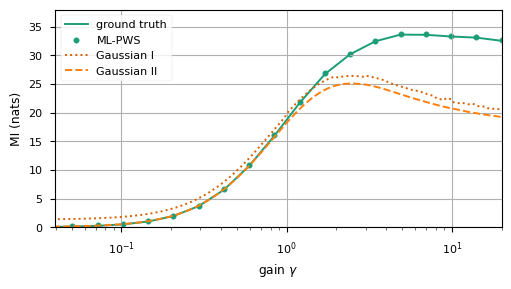

In [58]:
plt.style.use('seaborn-v0_8-paper')
def plot_gain_results(con):
    cnn_result = run_at_time(con, "2024-06-25_17-37-53").df()
    analytical_result = run_at_time(con, "2024-06-26_11-43-38").df()
    gaussian_result_large = con.sql('SELECT * FROM GaussianData WHERE sample_size = 100000').df()
    gaussian_result_small = con.sql('SELECT * FROM GaussianData WHERE sample_size = 1000').df()

    # width = 27/8
    width=5
    with plt.rc_context({'font.size': 8, 'lines.markersize': 4}):
        fig, ax = plt.subplots(figsize=(width, width/1.8), constrained_layout=True)
        colors = plt.get_cmap('Dark2').colors
        ax.set_prop_cycle(plt.cycler(color=colors))
        ax.plot(analytical_result.gain, analytical_result['mutual_information'], label='ground truth')
        ax.scatter(cnn_result.gain, cnn_result['mutual_information'], label='ML-PWS')
        ax.plot(gaussian_result_small.gain, gaussian_result_small['mutual information'], label='Gaussian I', ls=':')
        ax.plot(gaussian_result_large.gain, gaussian_result_large['mutual information'], label='Gaussian II', ls='--', color='C1')
        ax.set_xlabel('gain $\\gamma$')
        ax.set_ylabel('MI (nats)')
        ax.set_xscale('log')
        ax.set_ylim(0, 38)
        ax.set_xlim(10**-1.4, 20)
        ax.grid()
        ax.legend(loc='upper left')
    return fig
    
fig = plot_gain_results(con)
fig.savefig('../reports/figures/MI_gain.pdf')

fig